In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pathlib import Path
import yfinance as yf
import pandas_ta as ta
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')

# basic setup and read the data
cmap = cm.get_cmap('Pastel1')
PROJECT_DIR = Path().resolve()
data = pd.read_pickle(PROJECT_DIR / "processed_data/bonds-analyzed.pkl")

# in case, there is a problem...
copy = data.copy()

# Table of Contents
1. [Credit Risk and CDS Spreads](#1)
2. [Geopolitical Risks](#2)
3. [Liquidity and Bid-Ask Spreads](#3)
4. [A Closer Look at the U.S. Bonds...](#4)

***

### 1. Credit Risk and CDS Spreads

Drop countries if the **probability of default is more than 10\%**. For that, assumptions:
+ Recovery rate to be 40\% and loss severity to be 60\%
+ Using 5-yr CDS spreads as the benchmark

In [157]:
# loss severity is assumed to be 60%
loss_severity = 0.6

# probability of default using 5-yr CDS spreads
data['PD_5y_pct'] = data['Spread_5y'] / loss_severity / 100

# drop rows if default probability is higher than 10%
# if "<= 10", it also drops NaNs, so simply choose "not (> 10)"
data = data[~(data['PD_5y_pct'] > 10)]

In [158]:
diff_cntry = set(copy['Country']) - set(data['Country'])
print(diff_cntry)

{'Argentina', 'Pakistan', 'El Salvador', 'Tunisia', 'Egypt', 'Gabon', 'Ecuador'}


### 2. Geopolitical Risks
+ **Russia-Ukraine conflict** (+ **Belarus**, due to the sanctions)
+ **Israel-Hamas conflict** (+ **Lebanon**, due to the potential Hezbullah involvement)
+ **Azerbaijan-Armenia conflict**
+ **Argentina** and **Venezuela**, due to their idiosyncratic risks

In [159]:
data = data[~data['Country'].isin(['Lebanon', 'Argentina', 'Armenia', 'Russia', 'Israel', 'Ukraine', 'Belarus', 'Venezuela'])]

### 3. Liquidity and Bid-Ask Spreads

Before creating thresholds for the bid-ask spreads, I **drop CALLABLE and PUTABLE** since:
+ Anticipating interest rate cuts after 2024Q2
+ **“callable”:** cheaper re-financing for issuers → ***increasing reinvestment risk***
+ **“putable”:** declining rates → ***less value of put option***

In [160]:
data = data[~data['Mty Type'].isin(['CALLABLE', 'PUTABLE', 'CALL/SINK', 'CALL/PUT'])]

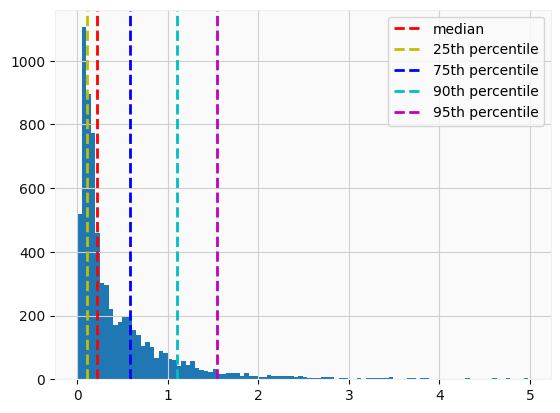

In [161]:
# Filter the data and calculate the median
filtered_data = data[data['Percentage Spread'] < 5]
median_value = filtered_data['Percentage Spread'].median()

# Calculate the percentiles
percentiles = [filtered_data['Percentage Spread'].quantile(i) for i in [0.25, 0.75, 0.90, 0.95]]

# Create the histogram
filtered_data['Percentage Spread'].hist(bins=100)

# Draw a vertical line at the median
plt.axvline(median_value, color='r', linestyle='dashed', linewidth=2, label='median')

# Draw vertical lines at the percentiles
colors = ['y', 'b', 'c', 'm']
labels = ['25th percentile', '75th percentile', '90th percentile', '95th percentile']
for percentile, color, label in zip(percentiles, colors, labels):
    plt.axvline(percentile, color=color, linestyle='dashed', linewidth=2, label=label)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### 4. A Closer Look at the U.S. Bonds...

In [167]:
us2y.columns

Index(['Issuer', 'Ticker', 'Amt Out', 'Cpn', 'Maturity', 'YTM - Ask',
       'YTM - Bid', 'Series', 'BBG Composite', 'Mty Type', 'Currency',
       'Country', 'Name_10y', 'Spread_10y', 'Change_10y', 'SD_10y', 'Low_10y',
       'High_10y', 'Avg_10y', '3M +/-_10y', '3M Chg_10y', 'Name_5y',
       'Spread_5y', 'Change_5y', 'SD_5y', 'Low_5y', 'High_5y', 'Avg_5y',
       '3M +/-_5y', '3M Chg_5y', 'Name_2y', 'Spread_2y', 'Change_2y', 'SD_2y',
       'Low_2y', 'High_2y', 'Avg_2y', '3M +/-_2y', '3M Chg_2y',
       'Years to Maturity', 'Face Value', 'Buy Price', 'Sell Price',
       'Macaulay Duration (Buy)', 'Macaulay Duration (Sell)',
       'Modified Duration (Buy)', 'Modified Duration (Sell)',
       'Convexity (Buy)', 'Convexity (Sell)', 'DV01', 'Buy-Sell Spread',
       'Percentage Spread', 'PD_5y_pct'],
      dtype='object')

In [163]:
us_data = data[data['Country'] == 'United States']
us1y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 1)]
us2y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)]
us5y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 5)]
us10y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 10)]
us_2_to_5 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 2) & (data['Years to Maturity'] <= 5)]
us_5_to_10 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 5) & (data['Years to Maturity'] <= 10)]
us_10_to_20 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 10) & (data['Years to Maturity'] <= 20)]
us_20_to_30 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 20) & (data['Years to Maturity'] <= 30)]

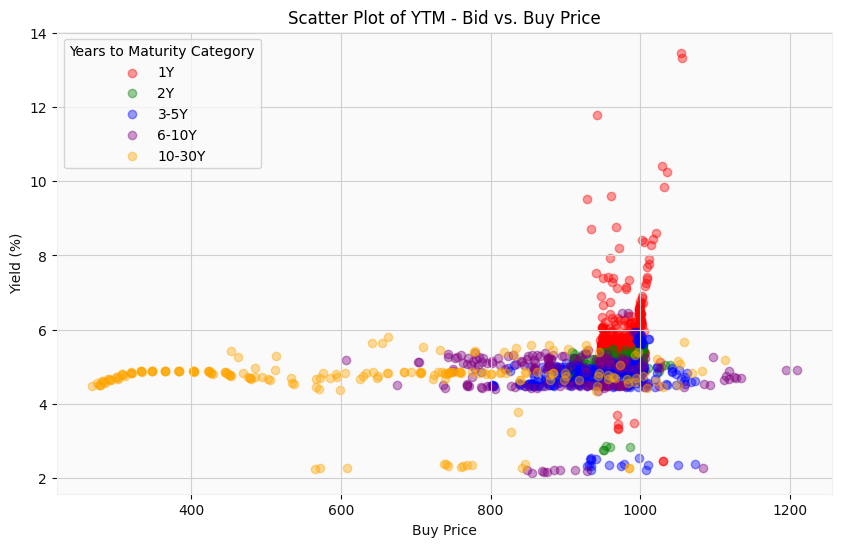

In [166]:
# Assuming 'portfolio' is your DataFrame with bond data
plt.figure(figsize=(10, 6))

# Filtering out negative 'YTM - Bid' values
filtered_data = us_data[us_data['YTM - Bid'] >= 0]

# Creating categorical 'Years to Maturity' bins
bins = [0, 1, 2, 5, 10, 30]
labels = ['1Y', '2Y', '3-5Y', '6-10Y', '10-30Y']
filtered_data['Years to Maturity Category'] = pd.cut(filtered_data['Years to Maturity'], bins=bins, labels=labels)

# Define a color map for the categories
category_colors = {'1Y': 'red', '2Y': 'green', '3-5Y': 'blue', '6-10Y': 'purple', '10-30Y': 'orange'}

# Map the category labels to colors
filtered_data['Color'] = filtered_data['Years to Maturity Category'].map(category_colors)

# Creating scatter plot with discrete colors
for category, color in category_colors.items():
    subset = filtered_data[filtered_data['Years to Maturity Category'] == category]
    plt.scatter(subset['Buy Price'], subset['YTM - Bid'], label=category, color=color, alpha=0.4)

# Adding labels
plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')

# Adding a legend
plt.legend(title='Years to Maturity Category')

# Adding a title
plt.title('Scatter Plot of YTM - Bid vs. Buy Price')

# Show the plot
plt.show()

### 4.1. Riding the Yield Curve with US2Y

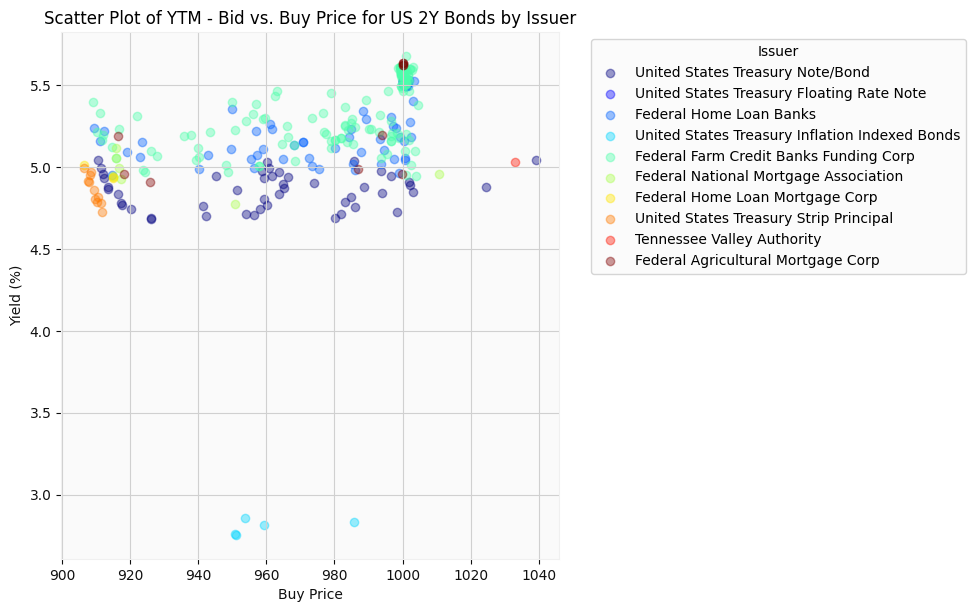

In [172]:
# Assuming us2y is your DataFrame for US bonds with 2 years to maturity
plt.figure(figsize=(10, 6))

# Filtering out negative 'YTM - Bid' values
filtered_us2y = us2y[us2y['YTM - Bid'] >= 0]

# Identify unique issuers
unique_issuers = filtered_us2y['Issuer'].unique()

# Assign a color to each issuer
# If there are too many issuers, consider using a colormap instead
colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))

# Map the issuer to colors
filtered_us2y['Color'] = filtered_us2y['Issuer'].map(issuer_colors)

# Creating scatter plot with discrete colors
for issuer, color in issuer_colors.items():
    subset = filtered_us2y[filtered_us2y['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Bid'], label=issuer, color=color, alpha=0.4)

# Adding labels
plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')

# Adding a legend
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Adding a title
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 2Y Bonds by Issuer')

# Show the plot
plt.show()

In [191]:
# sort by modified duration
us2y_sorted_by_duration = us2y.sort_values(by='Modified Duration (Buy)', ascending=False)

mean_spread_2y = us2y['Percentage Spread'].mean()
median_spread_2y = us2y['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 2-yr: {mean_spread_2y}
Median percentage spread of buy-sell prices for US 2-yr: {median_spread_2y}""")

# Exclude the ones with illiquidity and high price spread
subset_us2y_sorted_by_duration = us2y_sorted_by_duration[us2y['Percentage Spread'] <= median_spread_2y]

subset_us2y_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(20)

Mean percentage spread of buy-sell prices for US 2-yr: 0.19697924227565872
Median percentage spread of buy-sell prices for US 2-yr: 0.1606218703457926


,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
150,United States Treasury Note/Bond,0.25,4.83753,913.540,913.102,0.047945,1.996,1.949
240,United States Treasury Note/Bond,0.25,4.847783,913.357,912.860,0.054415,1.996,1.949
535,United States Treasury Note/Bond,0.25,4.90745,912.296,911.821,0.052066,1.996,1.948
495,United States Treasury Note/Bond,0.25,4.961335,911.339,910.819,0.057059,1.996,1.948
371,United States Treasury Note/Bond,0.375,4.741631,917.608,917.164,0.048387,1.994,1.948
457,United States Treasury Note/Bond,0.375,4.75338,917.398,916.969,0.046763,1.994,1.948
492,United States Treasury Note/Bond,0.25,4.932041,911.859,911.408,0.049459,1.996,1.948
545,United States Treasury Note/Bond,0.375,4.806725,916.445,915.985,0.050194,1.994,1.947
433,United States Treasury Note/Bond,0.25,5.010893,910.460,909.914,0.059970,1.996,1.947
500,United States Treasury Note/Bond,0.5,4.724219,920.278,919.933,0.037489,1.992,1.946


In [188]:
us2y_sorted_by_yield = subset_us2y_sorted_by_duration.sort_values(by='YTM - Ask', ascending=False)
us2y_sorted_by_yield[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(20)

,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
1134,Federal Farm Credit Banks Funding Corp,5.465,5.537197,998.651,997.376,0.127672,1.922,1.870
129,United States Treasury Floating Rate Note,5.52656,5.51383,1000.238,999.966,0.027194,1.921,1.869
3121,Federal Farm Credit Banks Funding Corp,5.475,5.510947,999.328,998.008,0.132089,1.921,1.869
1851,Federal Farm Credit Banks Funding Corp,5.475,5.505712,999.426,998.019,0.140781,1.921,1.870
1647,Federal Farm Credit Banks Funding Corp,5.48,5.498638,999.652,998.396,0.125644,1.921,1.870
3922,Federal Farm Credit Banks Funding Corp,5.475,5.495133,999.624,999.624,0.000000,1.921,1.870
1191,Federal Farm Credit Banks Funding Corp,5.475,5.495133,999.624,999.624,0.000000,1.921,1.870
2237,Federal Farm Credit Banks Funding Corp,5.475,5.494865,999.629,998.378,0.125146,1.921,1.870
2007,Federal Farm Credit Banks Funding Corp,5.48,5.49302,999.757,998.405,0.135233,1.921,1.870
2091,Federal Farm Credit Banks Funding Corp,5.515,5.488986,1000.486,998.895,0.159023,1.921,1.870


In [192]:
us2y_sorted_by_yield.shape

(163, 53)

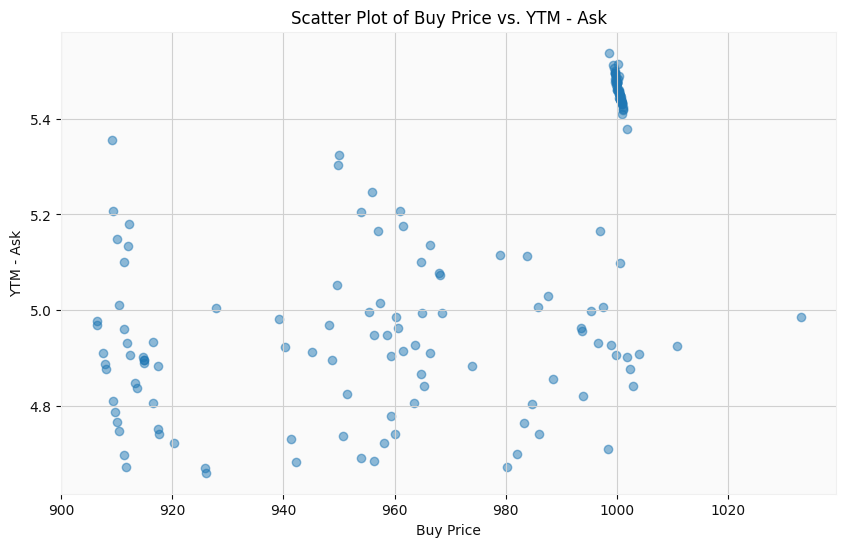

In [185]:
plt.figure(figsize=(10, 6))
plt.scatter(subset_us2y_sorted_by_duration['Buy Price'], subset_us2y_sorted_by_duration['YTM - Ask'], alpha=0.5)
plt.xlabel('Buy Price')
plt.ylabel('YTM - Ask')
plt.title('Scatter Plot of Buy Price vs. YTM - Ask')
plt.grid(True)
plt.show()

In [200]:
# since I assert 2Y yields will decline, for higher duration, drop the higher coupon bonds
final2y = us2y_sorted_by_yield[us2y_sorted_by_yield['Cpn'] <= 3]

In [203]:
print(f"""
Final subset for US 2yr has:
    Avg Yield: {round(final2y["YTM - Ask"].mean(), 3)}
    Avg Price: {round(final2y["Buy Price"].mean(), 3)}
    Avg Duration: {round(final2y["Macaulay Duration (Buy)"].mean(),3)}
    Avg Modified Duration: {round(final2y["Modified Duration (Buy)"].mean(),3)}
""")


Final subset for US 2yr has:
    Avg Yield: 4.915
    Avg Price: 932.635
    Avg Duration: 1.95
    Avg Modified Duration: 1.904



In [ ]:
# for a visual inspection and final selection
final2y[['Issuer', 'BBG Composite', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(60)

In [206]:
final2y.reset_index(inplace=True)

In [212]:
selected_indices = [0, 1, 21, 22, 57]
us2y_portfolio = final2y.iloc[selected_indices]

In [221]:
us2y_portfolio[["Initial Investment", "Price Change", "Absolute Price Change"]]

,Initial Investment,Price Change,Absolute Price Change
0,300000.0,0.01940,5820.0
1,300000.0,0.01909,5727.0
21,300000.0,0.01910,5730.0
22,300000.0,0.01948,5844.0
57,300000.0,0.01922,5766.0


In [219]:
print(f"""
Final subset for US 2yr has:
    Avg Yield: {round(us2y_portfolio["YTM - Ask"].mean(), 3)}
    Avg Price: {round(us2y_portfolio["Buy Price"].mean(), 3)}
    Avg Duration: {round(us2y_portfolio["Macaulay Duration (Buy)"].mean(),3)}
    Avg Modified Duration: {round(us2y_portfolio["Modified Duration (Buy)"].mean(),3)}
""")


Final subset for US 2yr has:
    Avg Yield: 5.068
    Avg Price: 936.338
    Avg Duration: 1.975
    Avg Modified Duration: 1.926



In [215]:
# Calculate the modified duration and convexity-weighted price change for each bond in the portfolio
us2y_portfolio['Price Change'] = (-us2y_portfolio['Modified Duration'] * (-0.01)) + (0.5 * us2y_portfolio['Convexity'] * (-0.01)**2)

# Calculate the initial investment for each bond
us2y_portfolio['Initial Investment'] = 1500000 / len(us2y_portfolio)

# Calculate the absolute price change for each bond
us2y_portfolio['Absolute Price Change'] = us2y_portfolio['Price Change'] * us2y_portfolio['Initial Investment']

# Calculate the total price change for the portfolio
total_price_change = us2y_portfolio['Absolute Price Change'].sum()

# Print the total price change
print(f'Total Price Change: ${total_price_change:.2f}')

Total Price Change: $28887.00


In [189]:
us2y["YTM - Bidka"].mean()


5.2011984278284045

In [211]:
yarak[['Issuer', 'BBG Composite', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(60)

,Issuer,BBG Composite,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
3327,Federal Farm Credit Banks Funding Corp,AA+,0.5,5.354643,909.074,908.374,0.077001,1.992,1.940
4639,Federal Farm Credit Banks Funding Corp,AA+,2.65,5.323598,949.905,948.578,0.139698,1.960,1.909
5252,Federal Home Loan Banks,AA+,2.625,5.302219,949.825,948.863,0.101282,1.960,1.909
6873,Federal Farm Credit Banks Funding Corp,AA+,2.9,5.24612,956.000,954.667,0.139435,1.956,1.906
4675,Federal Home Loan Banks,AA+,0.375,5.207504,909.328,908.828,0.054986,1.994,1.943
6870,Federal Farm Credit Banks Funding Corp,AA+,2.75,5.204511,953.944,952.607,0.140155,1.959,1.909
1181,Federal Home Loan Banks,AA+,0.5,5.180555,912.150,911.442,0.077619,1.992,1.942
2371,Federal Home Loan Banks,AA+,2.875,5.164959,957.012,955.999,0.105850,1.957,1.908
4997,Federal Farm Credit Banks Funding Corp,AA+,0.36,5.147841,910.101,908.935,0.128118,1.994,1.944
5380,Federal Farm Credit Banks Funding Corp,AA+,0.45,5.134294,912.031,911.005,0.112496,1.993,1.943


In [210]:
final2y[['Issuer', 'BBG Composite', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(60)

,Issuer,BBG Composite,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
0,Federal Farm Credit Banks Funding Corp,AA+,0.5,5.354643,909.074,908.374,0.077001,1.992,1.940
1,Federal Farm Credit Banks Funding Corp,AA+,2.65,5.323598,949.905,948.578,0.139698,1.960,1.909
2,Federal Home Loan Banks,AA+,2.625,5.302219,949.825,948.863,0.101282,1.960,1.909
3,Federal Farm Credit Banks Funding Corp,AA+,2.9,5.24612,956.000,954.667,0.139435,1.956,1.906
4,Federal Home Loan Banks,AA+,0.375,5.207504,909.328,908.828,0.054986,1.994,1.943
5,Federal Farm Credit Banks Funding Corp,AA+,2.75,5.204511,953.944,952.607,0.140155,1.959,1.909
6,Federal Home Loan Banks,AA+,0.5,5.180555,912.150,911.442,0.077619,1.992,1.942
7,Federal Home Loan Banks,AA+,2.875,5.164959,957.012,955.999,0.105850,1.957,1.908
8,Federal Farm Credit Banks Funding Corp,AA+,0.36,5.147841,910.101,908.935,0.128118,1.994,1.944
9,Federal Farm Credit Banks Funding Corp,AA+,0.45,5.134294,912.031,911.005,0.112496,1.993,1.943


In [39]:
# Suppose you want to select rows with index numbers 1, 5, 9, 10, 14, 95, and 129
selected_indices = [1, 5, 9, 10, 14, 95, 129]
subset_df = original_df.iloc[selected_indices]

,PD_5y_pct,Spread_5y
443,71.241167,4274.47
1634,71.241167,4274.47
2422,71.241167,4274.47
2417,71.241167,4274.47
1490,71.241167,4274.47
...,...,...
10021,NaN,NaN
10068,NaN,NaN
10100,NaN,NaN
10166,NaN,NaN


In [58]:
mean_values = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)][['YTM - Bid', 'YTM - Ask']].mean()
mean_values

YTM - Bid    5.201198
YTM - Ask    5.096969
dtype: object

In [59]:
mean_values = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 5)][['YTM - Bid', 'YTM - Ask']].mean()
mean_values

YTM - Bid    4.615165
YTM - Ask    4.515398
dtype: object

In [226]:
seri = data.Country.value_counts()
seri.head(20)

Country
United States    2531
Germany           778
France            617
Italy             255
Spain             246
South Korea       234
Netherlands       204
Belgium           202
Canada            202
China             160
Japan             119
Finland            80
Oman               64
Indonesia          59
Austria            57
Sweden             54
Turkey             54
Greece             53
Malta              52
Portugal           50
Name: count, dtype: int64

In [9]:
data = data[~data['Mty Type'].isin(['CALLABLE', 'PUTABLE', 'CALL/SINK', 'CALL/PUT'])]

In [41]:
data = data[~data['Country'].isin(['Lebanon', 'Argentina', 'Armenia', 'Russia', 'Israel', 'Ukraine', 'Belarus', 'Venezuela'])]

In [27]:
data.Issuer.value_counts().head(10)

Issuer
Federal Farm Credit Banks Funding Corp     800
Federal Home Loan Banks                    774
United States Treasury Note/Bond           335
Federal Home Loan Bank Discount Notes      170
State of North Rhine-Westphalia Germany    120
Italy Buoni Poliennali Del Tesoro          120
United States Treasury Strip Principal     114
BNG Bank NV                                 79
Caisse Francaise de Financement Local       74
Federal Farm Credit Discount Notes          72
Name: count, dtype: int64

In [28]:
fedfarm     = data[data["Issuer"] == "Federal Farm Credit Banks Funding Corp"]
fedhome     = data[data["Issuer"] == "Federal Home Loan Banks"]
us_treasury = data[data["Issuer"] == "United States Treasury Note/Bond"]
fedhomedisc = data[data["Issuer"] == "Federal Home Loan Bank Discount Notes"]
nrw         = data[data["Issuer"] == "State of North Rhine-Westphalia Germany"]
italy       = data[data["Issuer"] == "Italy Buoni Poliennali Del Tesoro"]
us_strips   = data[data["Issuer"] == "United States Treasury Strip Principal"]
bng         = data[data["Issuer"] == "BNG Bank NV"]
france      = data[data["Issuer"] == "Caisse Francaise de Financement Local"]
fedfarmdisc = data[data["Issuer"] == "Federal Farm Credit Discount Notes"]

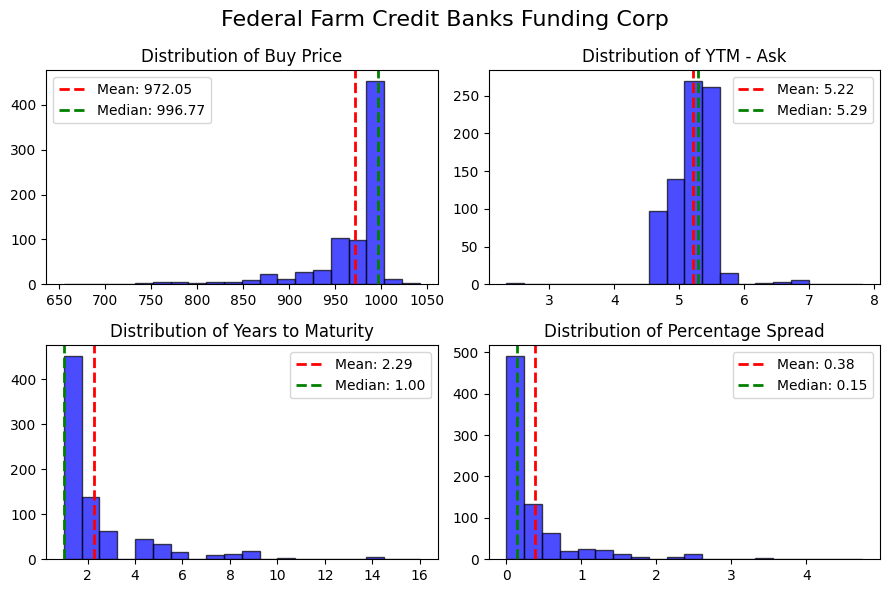

In [35]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Years to Maturity", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Years to Maturity", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(fedfarm[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = fedfarm[col].mean()
    median_val = fedfarm[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("Federal Farm Credit Banks Funding Corp", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

plt.savefig("figures/fedfarm.png")

# Display the plot
plt.show()

### Liquidity and Spreads

<Axes: >

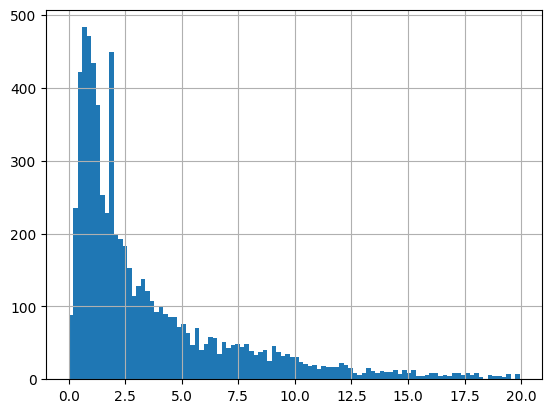

In [15]:
data[data['Buy-Sell Spread'] < 20]['Buy-Sell Spread'].hist(bins=100)

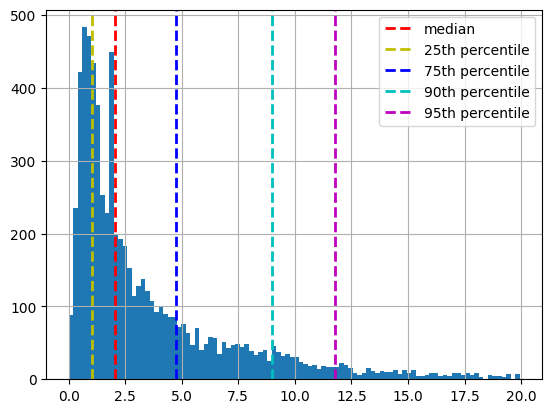

In [18]:
# Filter the data and calculate the median
filtered_data = data[data['Buy-Sell Spread'] < 20]
median_value = filtered_data['Buy-Sell Spread'].median()

# Calculate the percentiles
percentiles = [filtered_data['Buy-Sell Spread'].quantile(i) for i in [0.25, 0.75, 0.90, 0.95]]

# Create the histogram
filtered_data['Buy-Sell Spread'].hist(bins=100)

# Draw a vertical line at the median
plt.axvline(median_value, color='r', linestyle='dashed', linewidth=2, label='median')

# Draw vertical lines at the percentiles
colors = ['y', 'b', 'c', 'm']
labels = ['25th percentile', '75th percentile', '90th percentile', '95th percentile']
for percentile, color, label in zip(percentiles, colors, labels):
    plt.axvline(percentile, color=color, linestyle='dashed', linewidth=2, label=label)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [36]:
issuer_with_highest_avg_ytm_ask = data.groupby('Issuer')['YTM - Ask'].mean().idxmax()
issuer_with_highest_avg_ytm_ask

'Development Bank of the Republic of Belarus JSC'

In [49]:
unique_issuers = data[data['BBG Composite'] == 'BBB-']['Issuer'].unique()
print(unique_issuers)

['Hungary Government International Bond'
 'Panama Government International Bond'
 'Mexico Government International Bond' 'Panama Bonos del Tesoro'
 'Panama Notas del Tesoro' 'Export-Import Bank of India'
 'Romanian Government International Bond'
 'Kazakhstan Government International Bond'
 'Corp Financiera de Desarrollo SA' 'Autonomous Community of Catalonia'
 'Hellenic Republic Government International Bond'
 'Istituto per il Credito Sportivo'
 'Autonomous Community of Andalusia Spain' 'Region of Campania Italy'
 'Autonomous Region of the Azores' 'Cassa Depositi e Prestiti SpA']


In [61]:
macar = data[data["Issuer"]=='Hungary Government International Bond'][['Years to Maturity', 'YTM - Ask', 'Buy Price', 'Percentage Spread', 'BBG Composite', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']]

In [62]:
macar.head()

,Years to Maturity,YTM - Ask,Buy Price,Percentage Spread,BBG Composite,Macaulay Duration (Buy),Modified Duration (Buy)
222,17,6.884729,1073.502,0.592640,BBB-,10.058,9.723
490,1,5.248303,1001.219,0.463835,BBB-,0.987,0.962
1290,4,6.079547,1001.593,0.516377,BBB-,3.608,3.502
1368,6,6.113339,957.177,0.821896,BBB-,5.203,5.049
1420,11,6.461002,925.162,0.705066,BBB-,8.276,8.017


In [54]:
data[data["Issuer"]=='Hungary Government International Bond'][['Years to Maturity', 'YTM - Ask', 'Buy Price', 'Percentage Spread']].describe()

,Years to Maturity,YTM - Ask,Buy Price,Percentage Spread
count,20.000000,20.000000,20.000000,20.000000
mean,10.050000,5.508143,872.698550,0.888752
std,8.647939,0.872009,157.394616,0.420815
min,1.000000,3.990854,504.472000,0.463835
25%,4.000000,4.851111,759.279000,0.608745
50%,8.000000,5.315609,937.282000,0.795198
75%,11.250000,6.251047,986.585000,1.023790
max,29.000000,6.903047,1073.502000,2.325798


In [48]:
grouped_data = data.groupby('BBG Composite')[['YTM - Ask', 'YTM - Bid', 'Buy Price', 'Sell Price', 'Years to Maturity', 'Percentage Spread']].mean()
grouped_data

,YTM - Ask,YTM - Bid,Buy Price,Sell Price,Years to Maturity,Percentage Spread
BBG Composite,,,,,,
A,3.859530,4.041043,873.290108,867.357946,8.666667,0.747373
A+,4.714530,4.80507,910.699711,907.146226,6.314465,0.434088
A-,3.948126,4.141079,939.028382,932.307836,7.136364,0.736040
AA,4.518203,4.612055,907.720057,904.116582,6.347518,0.435587
AA+,4.811737,5.00122,951.655774,947.963153,3.727170,0.406676
AA-,4.151668,4.248821,914.469745,910.863052,7.021077,0.414575
AAA,4.215221,4.272439,913.394124,911.212314,5.772414,0.263829
B,9.515114,10.126866,879.689333,868.444667,5.833333,1.294461
B+,7.418533,7.86311,925.123689,914.087934,8.393443,1.200523


In [43]:
# Convert 'YTM - Ask' to numeric, errors='coerce' will set non-numeric values to NaN
data['YTM - Ask'] = pd.to_numeric(data['YTM - Ask'], errors='coerce')
top_10_issuers = data.groupby('Issuer')['YTM - Ask'].mean().nlargest(25)
top_10_issuers

Issuer
Zambia Government International Bond                          83.383004
Sri Lanka Government International Bond                       73.903020
Ethiopia International Bond                                   55.807869
Ghana Government International Bond                           33.541044
Pakistan Government International Bond                        25.003841
Tunisian Republic                                             24.229909
Ecuador Government International Bond                         24.109778
Pakistan Water & Power Development Authority                  22.949810
Bolivian Government International Bond                        22.038885
Republic of Maldives Ministry of Finance and Treasury Bond    20.179783
Pakistan Global Sukuk Programme Co Ltd/The                    18.830627
El Salvador Government International Bond                     17.183134
Egypt Treasury Bills                                          16.835000
Egypt Government International Bond                      

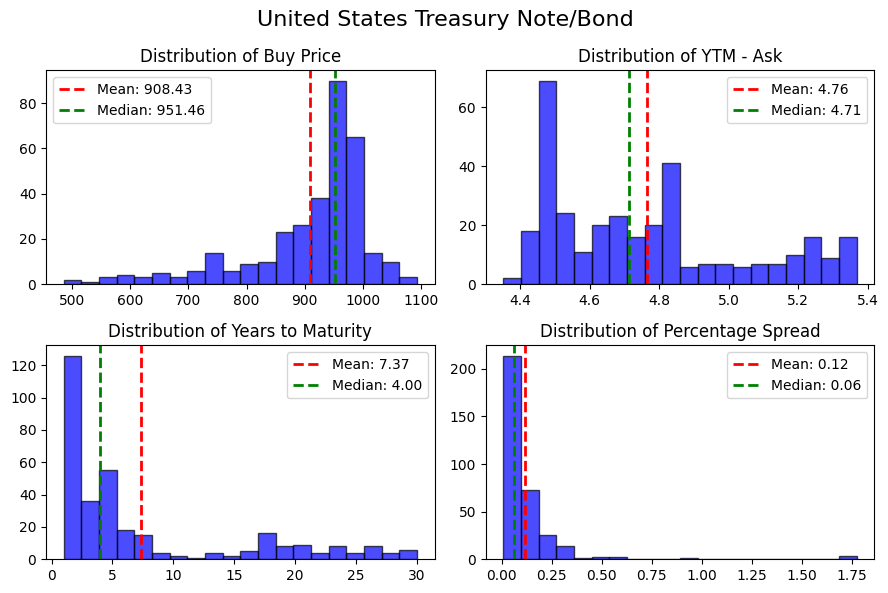

In [63]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Years to Maturity", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Years to Maturity", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(us_treasury[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = us_treasury[col].mean()
    median_val = us_treasury[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("United States Treasury Note/Bond", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

plt.savefig("figures/us_treasury.png")

# Display the plot
plt.show()


In [64]:
data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)][['YTM - Ask', 'Buy Price', 'Percentage Spread']].mean()

YTM - Ask              5.096969
Buy Price            975.311391
Percentage Spread      0.196979
dtype: float64

In [65]:
us2y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)]

In [69]:
us2y_treasury = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2) & (data['Issuer']=="United States Treasury Note/Bond")]

In [66]:
us2y.shape

(325, 52)

In [72]:
data.isna().sum()

Issuer                         0
Ticker                         0
Amt Out                        0
Cpn                            0
Maturity                       0
YTM - Ask                      0
YTM - Bid                      0
Series                      3637
BBG Composite               3334
Mty Type                       0
Currency                       0
Country                       10
Name_10y                     282
Spread_10y                   283
Change_10y                   282
SD_10y                       838
Low_10y                      282
High_10y                     282
Avg_10y                      282
3M +/-_10y                   282
3M Chg_10y                   282
Name_5y                      282
Spread_5y                    282
Change_5y                    282
SD_5y                        804
Low_5y                       282
High_5y                      282
Avg_5y                       282
3M +/-_5y                    308
3M Chg_5y                    288
Name_2y   

In [68]:
us2y.Issuer.value_counts()

Issuer
Federal Farm Credit Banks Funding Corp            138
Federal Home Loan Banks                           100
United States Treasury Note/Bond                   48
United States Treasury Strip Principal             11
Federal Agricultural Mortgage Corp                 10
Federal National Mortgage Association               7
United States Treasury Inflation Indexed Bonds      5
Federal Home Loan Mortgage Corp                     3
United States Treasury Floating Rate Note           2
Tennessee Valley Authority                          1
Name: count, dtype: int64

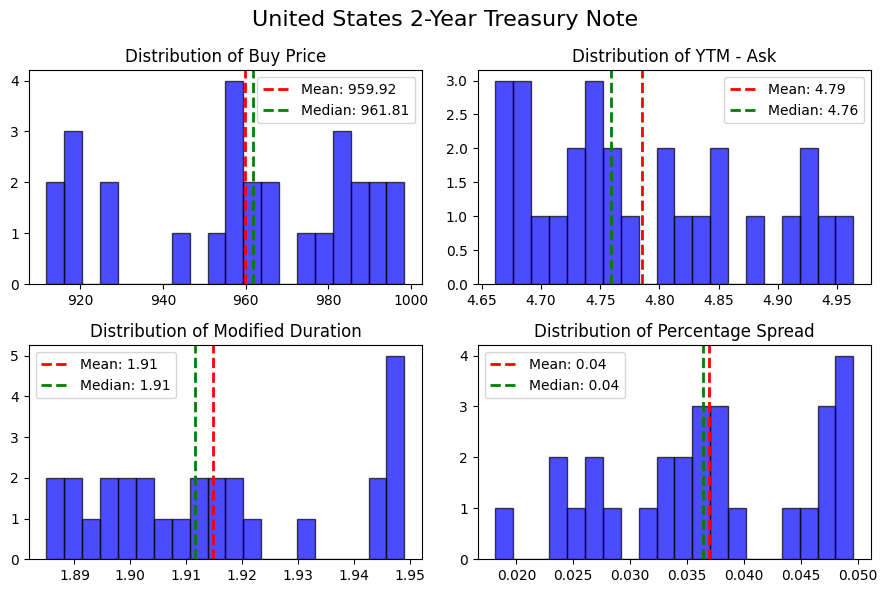

In [74]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Modified Duration (Buy)", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Modified Duration", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(us2y_treasury_subset[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = us2y_treasury_subset[col].mean()
    median_val = us2y_treasury_subset[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("United States 2-Year Treasury Note", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Save the plot as an image
plt.savefig("figures/us2y.png")

# Display the plot
plt.show()


In [71]:
us2y_treasury_subset = us2y_treasury[(us2y_treasury['Percentage Spread'] <= 0.05) & (us2y_treasury['Buy Price'] <= 1000)]

In [72]:
us2y_treasury_subset.shape

(28, 52)

In [64]:
data.columns

Index(['Issuer', 'Ticker', 'Amt Out', 'Cpn', 'Maturity', 'YTM - Ask',
       'YTM - Bid', 'Series', 'BBG Composite', 'Mty Type', 'Currency',
       'Country', 'Name_10y', 'Spread_10y', 'Change_10y', 'SD_10y', 'Low_10y',
       'High_10y', 'Avg_10y', '3M +/-_10y', '3M Chg_10y', 'Name_5y',
       'Spread_5y', 'Change_5y', 'SD_5y', 'Low_5y', 'High_5y', 'Avg_5y',
       '3M +/-_5y', '3M Chg_5y', 'Name_2y', 'Spread_2y', 'Change_2y', 'SD_2y',
       'Low_2y', 'High_2y', 'Avg_2y', '3M +/-_2y', '3M Chg_2y',
       'Years to Maturity', 'Face Value', 'Buy Price', 'Sell Price',
       'Macaulay Duration (Buy)', 'Macaulay Duration (Sell)',
       'Modified Duration (Buy)', 'Modified Duration (Sell)',
       'Convexity (Buy)', 'Convexity (Sell)', 'DV01', 'Buy-Sell Spread',
       'Percentage Spread', 'PD_5y_pct', 'bond-cds-spread'],
      dtype='object')

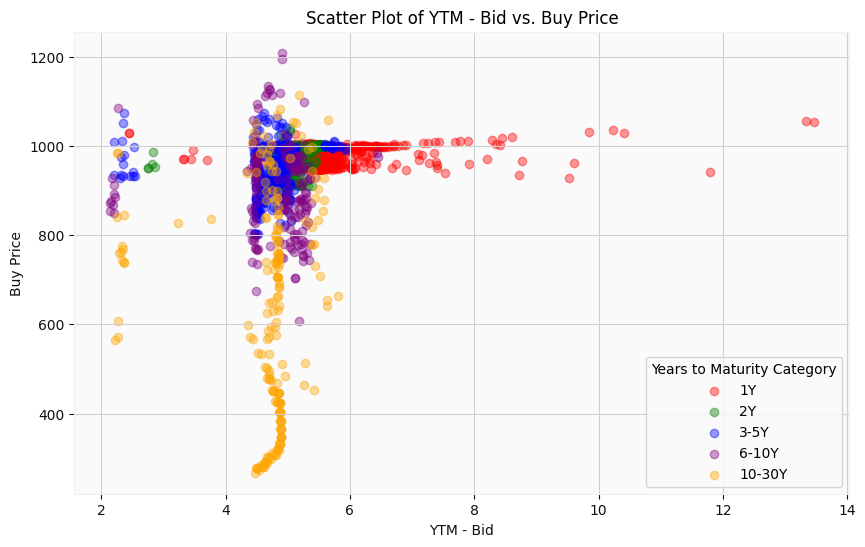

In [82]:
X_train_tensor

tensor([[-0.0658,  0.6688, -0.6528,  1.2060],
        [-0.0240, -0.6948,  1.1561, -0.3194],
        [-0.0445,  1.1234, -0.6867,  0.3539],
        ...,
        [-0.0241, -0.6948, -1.1294, -0.2321],
        [-0.0180, -0.6948,  2.3621, -0.3695],
        [ 0.0776,  1.2749,  1.1539,  0.5346]])

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class BondPriceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BondPriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


# Define a function to remove rows with NaN values from a NumPy array
def remove_nan_rows(X, y):
    nan_mask = ~np.isnan(X).any(axis=1)
    return X[nan_mask], y[nan_mask]

# Extract features and target variable
features = copy[['YTM - Bid', 'Years to Maturity', 'Cpn', 'Buy-Sell Spread']].values
target = copy['Buy Price'].values

# Convert data to float32
features = features.astype(np.float32)
target = target.astype(np.float32)

# Remove rows with NaN values from the dataset
features, target = remove_nan_rows(features, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define hyperparameter search space
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam
}

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

best_mse = float('inf')
best_hyperparameters = {}

# Hyperparameter search loop
for optimizer_name, optimizer_class in optimizers.items():
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Initialize the neural network model
            model = BondPriceModel(input_size=4, hidden_size=16, output_size=1)

            # Define the loss function (Mean Squared Error for regression)
            criterion = nn.MSELoss()

            # Initialize the optimizer
            optimizer = optimizer_class(model.parameters(), lr=lr)

            # Data preparation with PyTorch's TensorDataset and DataLoader
            train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).unsqueeze(1))
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            num_epochs = 10
            for epoch in range(num_epochs):
                model.train()
                for batch_x, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # Evaluate the neural network on the test dataset
            model.eval()
            with torch.no_grad():
                test_inputs = torch.FloatTensor(X_test)
                test_outputs = model(test_inputs)
                test_mse = mean_squared_error(y_test, test_outputs.numpy())

            # Update best hyperparameters based on lowest Mean Squared Error (MSE)
            if test_mse < best_mse:
                best_mse = test_mse
                best_hyperparameters = {
                    'optimizer': optimizer_name,
                    'learning_rate': lr,
                    'batch_size': batch_size
                }

print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best MSE:", best_mse)


ValueError: Input contains NaN.

In [119]:
pip install pandas_ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218924 sha256=4d66bd9571e3be130b2a09f14ac24289e4bccb687db1e86ac33bcd77225c8a8e
  Stored in directory: c:\users\yildi\appdata\local\pip\cache\wheels\69\00\ac\f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
Note: you may need to restart the kernel to use updated packages.


In [120]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta


In [121]:

# Define the ticker symbol for the U.S. 10-Year Treasury yield
ticker_symbol = "^TNX"

# Specify the start and end dates
start_date = "2022-11-24"  # Start date
end_date = "2023-11-24"    # End date

# Fetch historical data for the specified date range
data = yf.download(ticker_symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [127]:
# Calculate RSI
data['RSI'] = ta.rsi(data['Close'])

# Calculate Bollinger Bands
#data['BOLU'], data['BOLM'], data['BOLD'], data['BW'] = ta.bbands(data['Close'])

In [128]:
data.ta.bbands(close='Close', length=20, std=2, append=True)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
Date,,,,,
2022-11-25,NaN,NaN,NaN,NaN,NaN
2022-11-28,NaN,NaN,NaN,NaN,NaN
2022-11-29,NaN,NaN,NaN,NaN,NaN
2022-11-30,NaN,NaN,NaN,NaN,NaN
2022-12-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-11-16,4.385051,4.70390,5.022749,13.556796,0.094009
2023-11-17,4.358088,4.67975,5.001412,13.746966,0.128880
2023-11-20,4.327266,4.65895,4.990634,14.238568,0.142807


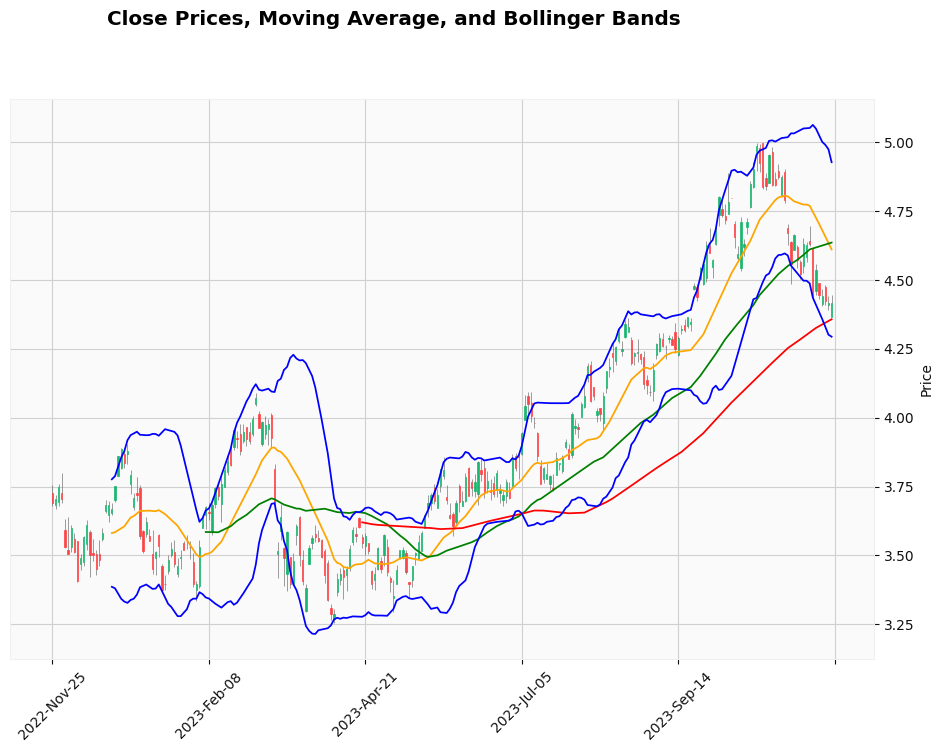

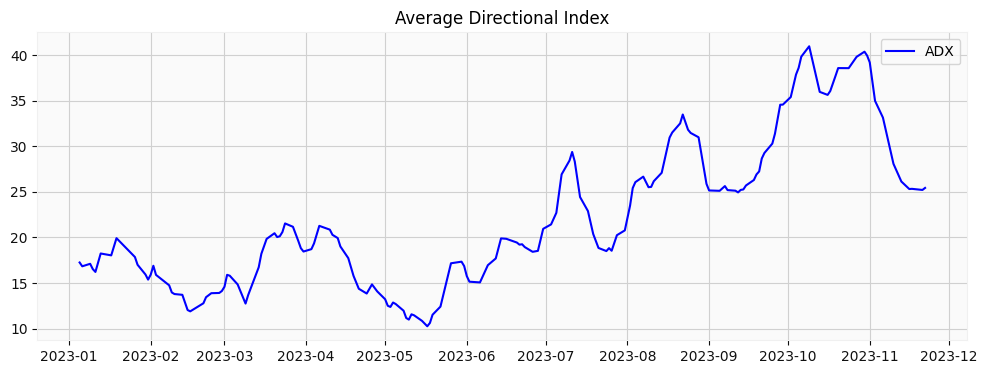

In [148]:
import mplfinance as mpf

# Calculate ADX, Moving Average, and Bollinger Bands
data.ta.adx(append=True)
data.ta.sma(close='Close', length=20, append=True)
data.ta.sma(close='Close', length=50, append=True)
data.ta.sma(close='Close', length=100, append=True)
data.ta.bbands(close='Close', length=20, std=2, append=True)

# Define additional plots for Moving Average and Bollinger Bands
apds = [mpf.make_addplot(data['SMA_20'], color='orange'),
        mpf.make_addplot(data['SMA_50'], color='green'),
        mpf.make_addplot(data['SMA_100'], color='red'),
        mpf.make_addplot(data['BBU_20_2.0'], color='blue'),
        mpf.make_addplot(data['BBL_20_2.0'], color='blue')]

# Create a candlestick chart with Moving Average and Bollinger Bands
mpf.plot(data, type='candle', style='yahoo', addplot=apds, figsize=(12, 8), title='Close Prices, Moving Average, and Bollinger Bands')

# Create a separate plot for the ADX
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['ADX_14'], label='ADX', color='blue')
plt.title('Average Directional Index')
plt.legend()

# Show the plots
plt.show()